# gp2Scale 
gp2Scale is a special setting in fvgp that combines non-stationary, compactly-supported kernels, HPC distributed computing, and sparse linear algebra to allow scale-up of exact GPs to millions of data points. gp2Scale holds the world record in this category! Here we run a moderately-sized GP, just because we assume you might run this locally.

I hope it is clear how cool it is what is happening here. If you have a dask client that points to a remote cluster with 500 GPUs, you will distribute the covariance matrix computation across those. The full matrix is sparse and will be fast to work with in downstream operations. The algorithm only makes use of naturally-occuring sparsity, so the result is exact in contrast to Vecchia or inducing-point methods.

In [1]:
##first install the newest version of fvgp
#!pip install fvgp==4.1.3

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp import GP
from dask.distributed import Client
%load_ext autoreload
%autoreload 2

client = Client() ##this is the client you can make locally like this or 
#your HPC team can provide a script to get it. We included an example to get gp2Scale going
#on Perlmutter


#It's good practice to make sure to wait for all the workers to be ready
client.wait_for_workers(4)

/home/marcus/VirtualEnvironments/fvgp_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44481 instead
  warnings.warn(


## Preparing the data and some other inputs

In [3]:
def f1(x):
    return ((np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)))

input_dim = 1
N = 10000
x_data = np.random.rand(N,input_dim)
y_data = f1(x_data)
hps_n = 2

hps_bounds = np.array([[0.1,10.],      ##signal var of Wendland kernel
                       [0.001,0.02]])  ##length scale for Wendland kernel
        

In [4]:
init_hps = np.random.uniform(size = len(hps_bounds), low = hps_bounds[:,0], high = hps_bounds[:,1])

my_gp2S = GP(1, x_data,y_data,init_hps,  #compute_device = 'gpu', #you can use gpus here
            gp2Scale = True, gp2Scale_batch_size= 1000, gp2Scale_dask_client = client, info = True
            )

my_gp2S.train(hyperparameter_bounds = hps_bounds, max_iter = 2)



Computing and transferring the covariance matrix took  5.706883430480957  seconds | sparsity =  0.0143805
MINRES solve in progress ... 1.3589859008789062e-05 seconds.
MINRES solve compute time:  1.5409257411956787 seconds.
logdet() in progress ...  1.5413587093353271 seconds.
                                    results                                   
     inquiries                            error            samples            
--------------------              ---------------------   ---------           
i         parameters       trace    absolute   relative   num   out  converged
1               none  -3.763e+04   6.908e+01     0.184%   100     0      False

                                    config                                    
                matrix                            stochastic estimator        
-------------------------------------    -------------------------------------
gram:                           False    method:                           slq
exponent:  

[6.60314243 0.01309385]


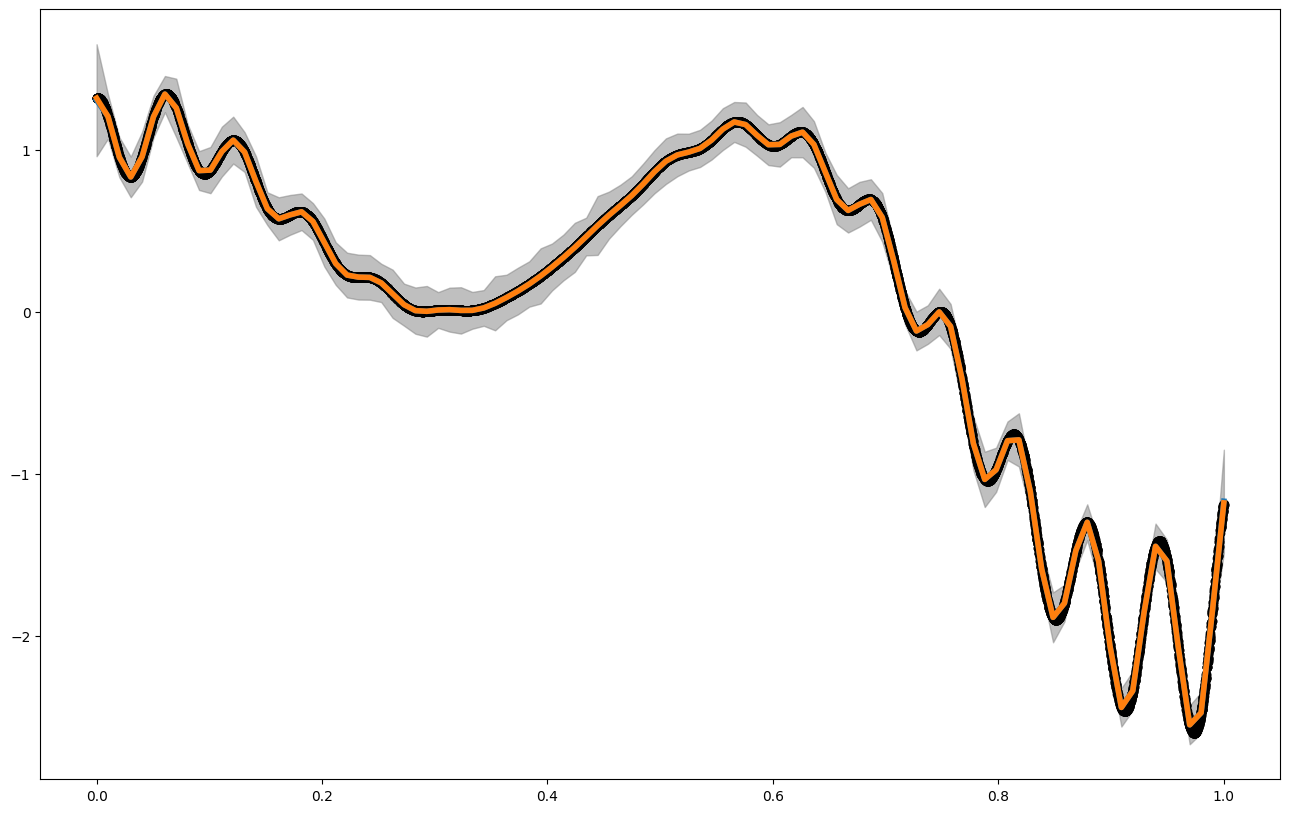

In [5]:
x_pred = np.linspace(0,1,100) ##for big GPs, this is usually not a good idea, but in 1d, we can still do it
                              ##It's better to do predicitons only for a handful of points.

mean1 = my_gp2S.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp2S.posterior_covariance(x_pred.reshape(-1,1), variance_only=False)["v(x)"]

print(my_gp2S.hyperparameters)

plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred,f1(x_pred), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')